# Disentanglement analysis of colored-bar-MNIST (Collider)

Here, we will load the embedded colored-bar-MNIST dataset, which when fed through the VAE produces a 32-dimensional embedding.

In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import math
import os
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets.utils as dataset_utils
from matplotlib.patches import Patch
from PIL import Image
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

from gendis.causal.modelv3 import CausalFlowModel, CausalNormalizingFlow
from gendis.datasets import MultiDistrDataModule
from gendis.variational.models.conv_vae import Conv_VAE

In [3]:
def show_imgs(imgs, title=None, row_size=4, figsize_scale=1.0, ytick_labels=None):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = (
        imgs.dtype == torch.int32
        if isinstance(imgs, torch.Tensor)
        else imgs[0].dtype == torch.int32
    )
    ncol = min(num_imgs, row_size)
    nrow = int(math.ceil(num_imgs / ncol))
    imgs = torchvision.utils.make_grid(
        imgs, nrow=row_size, pad_value=128 if is_int else 0.5
    )
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    fig, ax = plt.subplots(
        figsize=(figsize_scale * 1.5 * nrow * 2, figsize_scale * 1.5 * ncol)
    )
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    if title is not None:
        plt.title(title)
    # plt.axis("off")
    plt.axis("on")
    ax.set_xticks([])

    # if ytick_labels is not None:
    #     # Number of images per row
    #     img_per_row = num_imgs // nrow + (num_imgs % nrow > 0)
    #     # Set yticks at the center of each row of images
    #     yticks = [i * np_imgs.shape[1] / img_per_row + np_imgs.shape[1] / (2 * img_per_row) for i in range(img_per_row)]
    #     ax.set_yticks(yticks)
    #     ax.set_yticklabels(ytick_labels[:img_per_row])
    if ytick_labels is not None:
        # print(nrow)
        ax.set_yticks([(i + 0.5) * imgs.shape[1] / nrow for i in range(nrow)])
        ax.set_yticklabels(ytick_labels[:nrow])
    # ax.set_yticks([(i + 0.5) * images.shape[1] / nrow for i in range(nrow)])
    # plt.close()
    return fig, ax

In [65]:
root = "/Users/adam2392/pytorch_data/"
root = Path(root)
graph_type = "collider"
# root = "/Users/adam2392/pytorch_data/full-causal-mnistv2/"
# root = Path(root)
new_root = root / "vae-reduction"

batch_size = 20 * 5
num_workers = 1

data_module = MultiDistrDataModule(
    root=new_root,
    graph_type=graph_type,
    batch_size=batch_size,
    stratify_distrs=True,
    transform=None,
    num_workers=num_workers,
    dataset_name="digitcolorbar",
)
data_module.setup()

In [41]:
root = Path(f"/Users/adam2392/pytorch_data/data/causal/{graph_type}")

seed = 3
epoch = 309
step = 325500

# v2
# seed = 1
# epoch = 327
# step = 276504
results_dir = root / f"nfonvae-reduction-cosinelr-batch256-{graph_type}-seed={seed}"

checkpoint_fname = results_dir / f"epoch={epoch}-step={step}.ckpt"
model = CausalFlowModel.load_from_checkpoint(checkpoint_fname)

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [31]:
latent_embeddings = {
    "digit": np.arange(0, 8, dtype=int),
    "color-digit": np.arange(8, 16, dtype=int),
    "color-bar": np.arange(16, 24, dtype=int),
    "style": np.arange(24, 32, dtype=int),
    # "color-digit": np.arange(11, 22, dtype=int),
    # "color-bar": np.arange(22, 32, dtype=int),
}

## Investigate MCC

In [10]:
imgs = []
labels = []
targets = []

for idx in data_module.train_dataset.indices:
    img, label, target = data_module.dataset[idx]
    imgs.append(img)
    labels.append(label)
    targets.append(target)

imgs = torch.vstack(imgs)
labels = torch.vstack(labels)
targets = torch.vstack(targets)
print(imgs.shape, labels.shape, targets.shape)

torch.Size([270000, 32]) torch.Size([270000, 4]) torch.Size([270000, 3])


In [11]:
from tqdm import tqdm

# now forward these through the model
indices = np.arange(len(imgs))
embeddings = []

for idx in tqdm(np.array_split(indices[::10], 100)):
    this_embedding = model.model.inverse(imgs[idx, ...])
    embeddings.append(this_embedding)

embeddings = torch.vstack(embeddings)
print(embeddings.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.20it/s]


torch.Size([27000, 32])


In [13]:
# trim labels and targets too
labels = labels[::10]
print(labels.shape)
targets = targets[::10]
print(targets.shape)

torch.Size([27000, 4])
torch.Size([27000, 3])


In [29]:
# now create a y for each latent factor
latent_targets = {
    "digit": 0,
    "color-digit": 1,
    "color-bar": 2,
}

latent_names = ["digit", "color-digit", "color-bar", "style"]
n_repeats = 10

# (n_repeats, Vhat, V)
corr_arr = np.zeros((n_repeats, len(latent_names), len(latent_names)))

for rdx, random_state in enumerate(
    np.random.SeedSequence(1234).generate_state(n_repeats)
):
    cv = ShuffleSplit(n_splits=1, random_state=random_state)

    for i, name_src in enumerate(latent_names):
        jdx = latent_embeddings[name_src]
        X = embeddings[:, jdx].detach().numpy()

        for j, name_target in enumerate(latent_names):
            if name_target == "style":
                y = np.random.uniform(size=(len(labels)))
            else:
                idx = latent_targets[name_target]
                y = labels[:, idx].detach().numpy()
            # print(name_src, name_target, y.shape)
            reg = LinearRegression(fit_intercept=True)
            # reg = RandomForestRegressor(max_features=0.3, random_state=random_state)
            r2s = cross_val_score(reg, X, y=y, cv=cv, scoring="r2")
            # corr_coefficients = np.mean(
            #     np.sqrt(r2s)
            # )  # To be comparable to MCC (this is the average of R = coefficient of multiple correlation)
            # print(X.shape, y.shape, r2s.shape, corr_coefficients.shape)
            corr_arr[rdx, i, j] = r2s.squeeze()  # corr_coefficients
            # corr_arr[rdx, i, j] = corr_coefficients

(160, 4)
(120, 4)


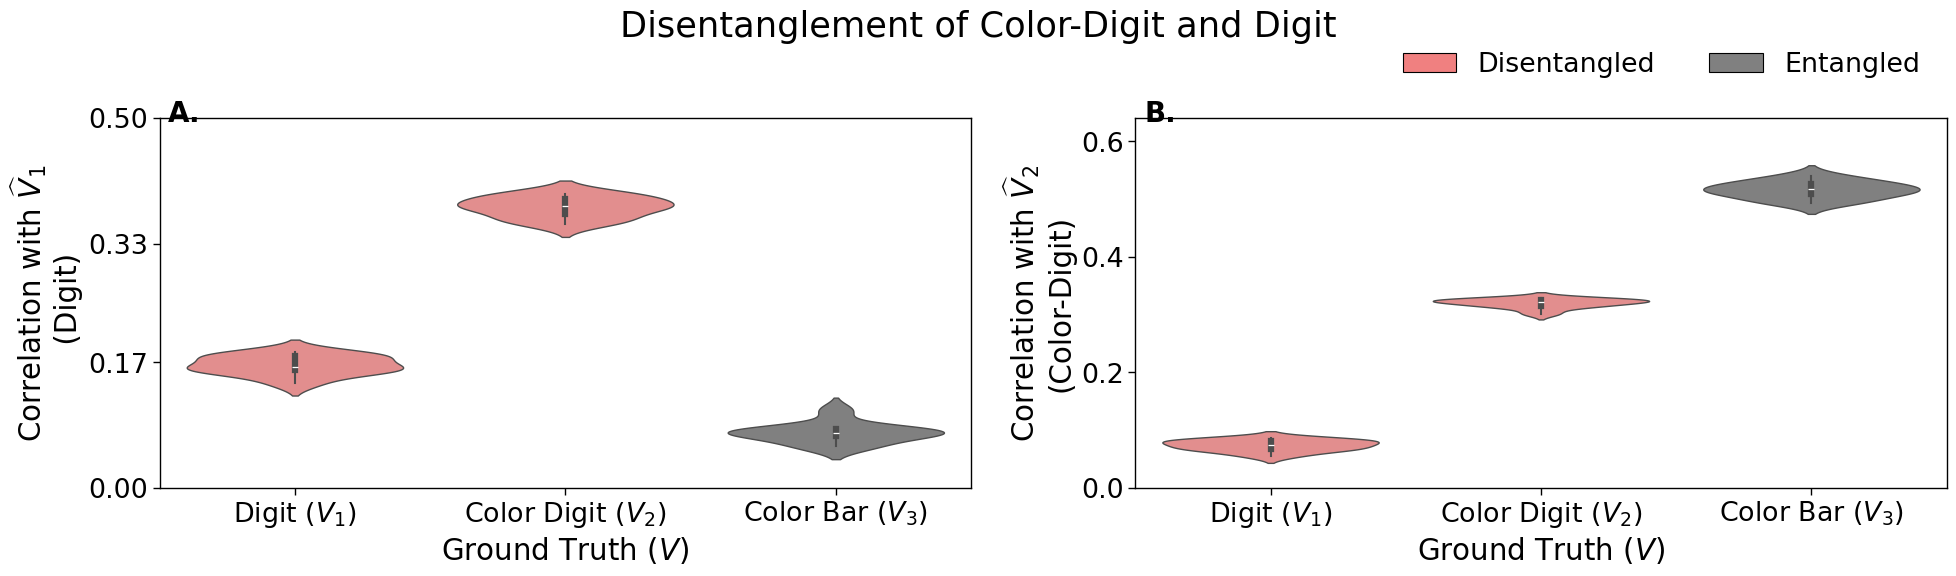

In [30]:
sns.set_context("paper", font_scale=2.2, rc={"font.weight": "bold"})
max_yticks = 4

# Reshape corr_arr to long format
data = []
for rdx in range(n_repeats):
    for i, name_src in enumerate(latent_names):
        for j, name_target in enumerate(latent_names):
            data.append([rdx, name_src, name_target, corr_arr[rdx, i, j]])

# Create a DataFrame
df = pd.DataFrame(data, columns=["repeat", "Vhat", "V", "correlation"])

# Define the mapping dictionary
mapping = {
    "digit": "Digit ($V_1$)",
    "color-digit": "Color Digit ($V_2$)",
    "color-bar": "Color Bar ($V_3$)",
    "style": "Style ($V_4$)",
}

print(df.shape)
df = df[~df["V"].isin(["style"])]
print(df.shape)

# Apply the mapping to the "V" column
df["V"] = df["V"].map(mapping)

# Filter the data for 'color-digit' and 'color-bar'
df_firstplot = df[df["Vhat"] == "digit"]
df_secondplot = df[df["Vhat"] == "color-digit"]

first_ylabel = "Correlation with $\widehat{V}_1$\n (Digit)"
second_ylabel = "Correlation with $\widehat{V}_2$\n(Color-Digit)"

palette = {
    "Color Digit ($V_2$)": "lightcoral",
    "Digit ($V_1$)": "lightcoral",
    "Color Bar ($V_3$)": "gray",
    "Style ($V_4$)": "gray",
}

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for 'digit'
sns.violinplot(
    x="V",
    y="correlation",
    hue="V",
    data=df_firstplot,
    ax=axes[0],
    density_norm="width",
    palette=palette,
)
# Define the desired y-ticks
# yticks = [0, df_color_digit["correlation"].max()]
# axes[0].set_yticks(yticks)
# axes[0].set_title("Disentanglement of Color-Digit")
axes[0].set_xlabel("Ground Truth ($V$)")
axes[0].set_ylabel(first_ylabel)
axes[0].set_ylim(0, df_firstplot["correlation"].max() + 0.1)
# Set yticks to display at most `max_yticks` points
yticks = axes[0].get_yticks()
if len(yticks) > max_yticks:
    yticks = np.round(np.linspace(yticks[0], yticks[-1], max_yticks), 2)
axes[0].set_yticks(yticks)

# Plot for 'color-bar'
sns.violinplot(
    x="V",
    y="correlation",
    hue="V",
    data=df_secondplot,
    ax=axes[1],
    density_norm="width",
    palette=palette,
)
# Define the desired y-ticks
# yticks = [0, df_color_bar["correlation"].max()]
# axes[1].set_yticks(yticks)
# Set yticks to display at most `max_yticks` points
yticks = axes[1].get_yticks()
if len(yticks) > max_yticks:
    yticks = np.round(np.linspace(yticks[0], yticks[-1], max_yticks), 2)
axes[1].set_yticks(yticks)
axes[1].set_ylim(0, df_secondplot["correlation"].max() + 0.1)
# axes[1].set_title("Disentanglement of Color-Bar")
axes[1].set_xlabel("Ground Truth ($V$)")
axes[1].set_ylabel(second_ylabel)

# Add labels A and B
axes[0].text(
    0.05,
    1.05,
    "A.",
    transform=axes[0].transAxes,
    fontsize=20,
    fontweight="bold",
    va="top",
    ha="right",
)
axes[1].text(
    0.05,
    1.05,
    "B.",
    transform=axes[1].transAxes,
    fontsize=20,
    fontweight="bold",
    va="top",
    ha="right",
)
fig.suptitle("Disentanglement of Color-Digit and Digit")

# Create custom legend
legend_elements = [
    Patch(facecolor="lightcoral", edgecolor="k", label="Disentangled"),
    Patch(facecolor="gray", edgecolor="k", label="Entangled"),
]

# Add legend to the plot
fig.legend(
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(0.7, 0.95),
    ncol=2,
    # title="CRIDOutput",
    frameon=False,
)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

# Save the figure if needed
fig.savefig(f"/Users/adam2392/Downloads/mcc_{graph_type}.pdf", bbox_inches="tight")

## Investigate MCC

## Investigate Downstream task of Image Editing

In [66]:
data_root = Path("/Users/adam2392/pytorch_data/")

graph_type = "collider"
seed = 1
model_root = (
    data_root
    / "vae-reduction"
    / f"vae-reduction-cosinelr-batch32-{graph_type}-seed={seed}"
    / "epoch=836-step=6620670.ckpt"
)
# load vae model
vae_model = Conv_VAE.load_from_checkpoint(model_root)

In [67]:
train_iter = iter(data_module.train_dataloader())

In [149]:
# randomly sample
batch = next(train_iter)
sample_imgs, sample_labels, sample_target = batch

print(sample_imgs.shape, sample_labels.shape, sample_target.shape)

torch.Size([100, 32]) torch.Size([100, 4]) torch.Size([100, 3])


In [150]:
print(data_module.dataset)
unique_rows = np.unique(data_module.dataset.intervention_targets, axis=0)
print("Unique intervention targets: ", unique_rows)

Unique intervention targets:  [[0 0 0]
 [1 1 0]]


In [151]:
# Initialize an empty list to hold the sorted rows
sorted_rows = []
distribution_indices = sample_labels[:, -1]
# Loop through the unique distribution indices
for i in range(5):  # Assuming unique distribution indices are 0, 1, 2, and 3
    # Get the indices where the distribution index equals i
    indices = (distribution_indices == i).nonzero(as_tuple=True)[0]
    # Append the corresponding rows to the sorted_rows list
    sorted_rows.append(sample_imgs[indices])

# Concatenate the sorted rows into a single tensor
sorted_imgs = torch.cat(sorted_rows, dim=0)

with torch.no_grad():
    images = vae_model.decoder(sorted_imgs)
images = vae_model.scale_image(images)

print(images.shape)
# fig, ax = show_imgs(
#     images,
#     row_size=40,
#     ytick_labels=["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Color Digit"],
#     figsize_scale=4.0
# )
# ax.set_yticklabels(["Obs", "Int. Color-Bar", "Int. Color-Bar", "Int. Width"])
# ax.set_yticks([(i + 0.5) * images.shape[1] / nrow for i in range(nrow)])
# ax.set_yticklabels()

torch.Size([100, 3, 28, 28])


# Intervene on Causal Prior to change the embeddings

In [156]:
# get observational images and their priors in the NF
obs_idx = np.argwhere(sample_labels[:, -1] == 0)[0]
obs_imgs = sample_imgs[obs_idx, ...]

# now forward these through the model
obs_embeddings = model.model.inverse(obs_imgs)

# intervene on the embedding in the relevant space
intervened_var = "digit"
v_idx = latent_embeddings[intervened_var]
print(v_idx)
print(obs_embeddings.shape)
perturb_size = obs_embeddings[:, v_idx].shape
n_samples = obs_embeddings.shape[0]
# obs_embeddings[:, v_idx] += torch.ones(perturb_size) * 0.1
# print(np.random.permutation(n_samples))
new_arr = obs_embeddings[:, v_idx]
# permute_idx = np.random.permutation(n_samples)
# print(permute_idx)
# new_arr = new_arr[permute_idx]
# print(new_arr.shape)
# obs_embeddings[:, v_idx] = new_arr  # * -1.0
obs_embeddings[:, v_idx] += torch.Tensor(
    # np.random.randint(-1, 1, size=obs_embeddings[:, v_idx].shape) *
    1.0
    * np.random.normal(0.1, 1.0, size=obs_embeddings[:, v_idx].shape)
    # 0.75
    # * np.random.normal(-0.75, 0.25, size=obs_embeddings[:, v_idx].shape)
)
# print(embeddings.shape)
print(obs_imgs.shape)

intervened_imgs = model.model.forward(obs_embeddings)
print(intervened_imgs.shape)

[0 1 2 3 4 5 6 7]
torch.Size([20, 32])
torch.Size([20, 32])
torch.Size([20, 32])


In [157]:
print(intervened_imgs.shape)
with torch.no_grad():
    observed_imgs = vae_model.decoder(obs_imgs)
observed_imgs = vae_model.scale_image(observed_imgs)
with torch.no_grad():
    intervened_imgs = vae_model.decoder(intervened_imgs)
intervened_imgs = vae_model.scale_image(intervened_imgs)
print(intervened_imgs.shape)
print(obs_imgs.shape)

torch.Size([20, 32])
torch.Size([20, 3, 28, 28])
torch.Size([20, 32])


In [158]:
images = torch.vstack((observed_imgs, intervened_imgs))
save_image(
    intervened_imgs,
    f"/Users/adam2392/Downloads/int-{intervened_var}-batch20-{graph_type}.pdf",
    nrow=5,
)
print(images.shape)

torch.Size([40, 3, 28, 28])


In [155]:
save_image(
    observed_imgs,
    f"/Users/adam2392/Downloads/obs-batch16-{graph_type}.pdf",
    nrow=5,
)

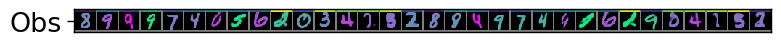

In [61]:
images = torch.vstack((observed_imgs, intervened_imgs))
fig, ax = show_imgs(
    images, row_size=40, ytick_labels=["Obs", "Int. Color-Bar"], figsize_scale=3.0
)
# fig.savefig(
#     "/Users/adam2392/Downloads/batch16-v1-disentanglecolorbar.pdf", bbox_inches="tight"
# )

In [188]:
print(obs_embeddings[:, v_idx].detach().numpy())

[[-2.7220745  -1.9373041  -1.6980088  -4.4590836  -1.6825417  -1.3926399
  -2.9608727  -1.5782013  -2.0492282 ]
 [-3.167306   -2.109361   -1.4970746  -2.4686334  -2.9619687  -0.6925008
  -3.0035253  -1.2747737  -2.0203736 ]
 [-2.958283   -1.9826937  -1.4030273  -2.9947424  -1.535905   -1.1043533
  -2.4996316  -0.91895914 -2.6959033 ]
 [-3.6884556  -2.851555   -2.4255204  -1.2679508  -2.3818612  -3.3998618
  -2.8481667  -1.5534832  -2.8809555 ]]
